<a href="https://colab.research.google.com/github/CodeChef-1/comp215/blob/main/labs/lab04-more_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COMP 215 - LAB 4
----------------
#### Name(s):
#### Date:

By the end of this lab you should be able to:
  * use composition and inheritance in a `class` to categorize related information


During this lab, you will be introduced to the following:
  * something, something



## Near Earth Objects (with more classes)

We'll continue working with Near Earth Object data using NASA's API: https://api.nasa.gov/.  In Lab 3 we defined an Asteroid class that contained a simple data structure.  In this lab, we will be Here's a brief review from Lab 2 on how to use the API.  

In [2]:
# import necessary modules
import datetime, json, requests
from pprint import pprint

### Review: make an API query

Here's a query that gets the record for a single NEO that recently passed by.

In [3]:
#API_KEY = 'DEMO_KEY'  # substitute your API key here
API_KEY = 'QMU73gySBTeUk6FVRje8eMwNOFfI1FZOwRtlf0Xo'

def get_neos(start_date):
    """ Return a list of NEO for the week starting at start_date """
    url = f'https://api.nasa.gov/neo/rest/v1/feed?start_date={start_date}&api_key={API_KEY}'
    # Fetch last week's NEO feed
    response = requests.request("GET", url, headers={}, data={})
    data = json.loads(response.text)
    #pprint(data)
    print(f'{data["element_count"]} Near Earth Objects found for week of {start_date}')
    return [neo for dated_records in data['near_earth_objects'].values() for neo in dated_records ]

def get_neo(id):
    """ Return a NEO record for the given id """
    url = f'https://api.nasa.gov/neo/rest/v1/neo/{id}?api_key={API_KEY}'
    response = requests.request("GET", url, headers={}, data={})
    return json.loads(response.text)

week_start = '2023-01-15'
neos = get_neos(week_start)
assert len(neos) > 0, f'Oh oh!  No NEOs found for {week_start}'
neo = get_neo(neos[-1]['id'])  # get the very latest NEO
print(f"Record for NEO ID {neos[-1]['id']} is:")
pprint(neo)

17 Near Earth Objects found for week of 2023-01-15
Record for NEO ID 3605885 is:
{'absolute_magnitude_h': 20.89,
 'close_approach_data': [{'close_approach_date': '1904-06-25',
                          'close_approach_date_full': '1904-Jun-25 10:33',
                          'epoch_date_close_approach': -2067600420000,
                          'miss_distance': {'astronomical': '0.3592609618',
                                            'kilometers': '53744674.659431366',
                                            'lunar': '139.7525141402',
                                            'miles': '33395392.2684542108'},
                          'orbiting_body': 'Earth',
                          'relative_velocity': {'kilometers_per_hour': '87745.0891583549',
                                                'kilometers_per_second': '24.3736358773',
                                                'miles_per_hour': '54521.3860939789'}},
                         {'close_approach_date': '190

## Exercise 1: Define a CloseApproach class

Each NEO record comes with a list of `close_approach_data`, where each record in this list represents a single “close approach” to another orbiting body.
1. Develop a class named `CloseApproach` to represent a single close approach record.  State variables are

        neo (refrence to related NEO object)
        orbiting body (str)
        approach date (datetime object!)
        miss distance (float - choose units, document it, and be consistent!)
        relative velocity (ditto)
  
2. Define a "Factory" class method to construct a `CloseApproach` object from one close approach data record (a dictionary object). This method takes a `neo` object as input for the NEO to which the close approach data belongs. Remember to parse the date/time string into a datetime object.

In [30]:
import datetime

class CloseApproach:
    def __init__(self, neo, orbiting_body, approach_date, miss_distance, relative_velocity):
        self.neo = neo
        self.orbiting_body = orbiting_body
        self.approach_date = approach_date
        self.miss_distance = miss_distance  # in kilometers
        self.relative_velocity = relative_velocity  # in kilometers per second

    @classmethod
    def from_dict(cls, neo):
        approach_data = neo['close_approach_data']
        approach_date = approach_data['close_approach_date']
        miss_distance_km = float(approach_data['miss_distance']['kilometers'])
        relative_velocity_km_s = float(approach_data['relative_velocity']['kilometers_per_second'])

        return cls(neo, approach_data['orbiting_body'], approach_date, miss_distance_km, relative_velocity_km_s)


# Example usage

neo_data_example = get_neo(54339874)
test_approach = CloseApproach.from_dict(neo_data_example['close_approach_data'])
print(test_approach.neo)
#code did not function properly so i let gemini correct some mistakes

TypeError: list indices must be integers or slices, not str

## Exercise 2: Add list of CloseApproach objects to the Asteroid

Define an `Asteroid` class, like you did in Lab 3, but give the `Asteroid` list of “close approaches”.  This is called *composition* because each Asteroid object will be *composed* of CloseApproach objects (plus some other things).  There is bit of a catch-22 here because we need the `Asteroid` to construct the `CloseApproach` objects. The first two steps deal with that:

1. Add an instance variable to your Asteroid class with a default value of an empty list:

    ```
    close_approaches:list = []
    ```
      
2. In the Asteroid `from_NEO` factory, use a list comprehension to build the list of `CloseApproach` objects for the Asteroid instance, and then set the instance's `close_approaches` variable before returning it. Setting the value of an object's instance variables from outside the class is generally frowned upon - this is why we make the factory a method of the class itself.

3. Add a method to `Asteroid` to return the `CloseApproach` object for the nearest miss (ie. smallest `missed_distance`):
    ```
    def nearest_miss(self):
        ...
    ```

4. Add a method to the Asteroid class, `closest_earth_approach`, that returns the CloseApproach object that represents the closest approach the Asteroid makes to Earth.
    ```
    def closest_earth_approach(self):
        ...
      
    ```

Write some test code to demonstrate these new features.

In [1]:
class Asteroid:

    close_approaches: list = []

    def __init__(self, designation: str, name: str, diameter: float, hazardous: bool):
        self.designation = designation
        self.name = name
        self.diameter = diameter
        self.hazardous = hazardous

    @classmethod
    def from_NEO(self, neos):
      for neo in neos:
        close_approaches = [CloseApproach.from_neo(neo, approach_data) for approach_data in neo['close_approach_data']]

    def nearest_miss(self):
      return min(self.close_approaches, key=lambda x: x.miss_distance)

    def closest_earth_approach(self):
      return min(self.close_approaches, key=lambda x: x.approach_date)

   #gemini showed me what the lambda func does, it makes a small unamed function, this should only be used in very small segments of code

neo_data_example = get_neo(54339874)
asteroid = Asteroid.from_NEO(neo_data_example)


SyntaxError: incomplete input (<ipython-input-1-fe747b45c4b7>, line 26)

## Exercise 3: Plot the Closest Approaches

Write a function that takes an Asteroid object as a parameter and makes a timeline plot of close approaches.  You may wish to use the `matplotlib.pyplot` `plot` object.  Here is an example of a timeline plot for the asteroid with neo id '54339874'

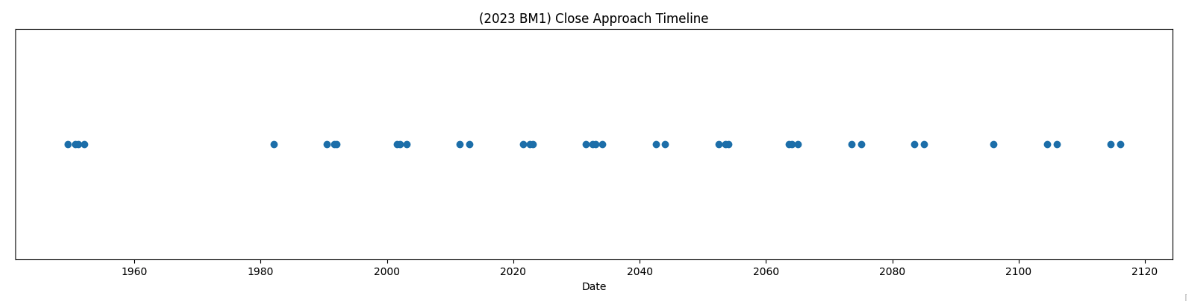

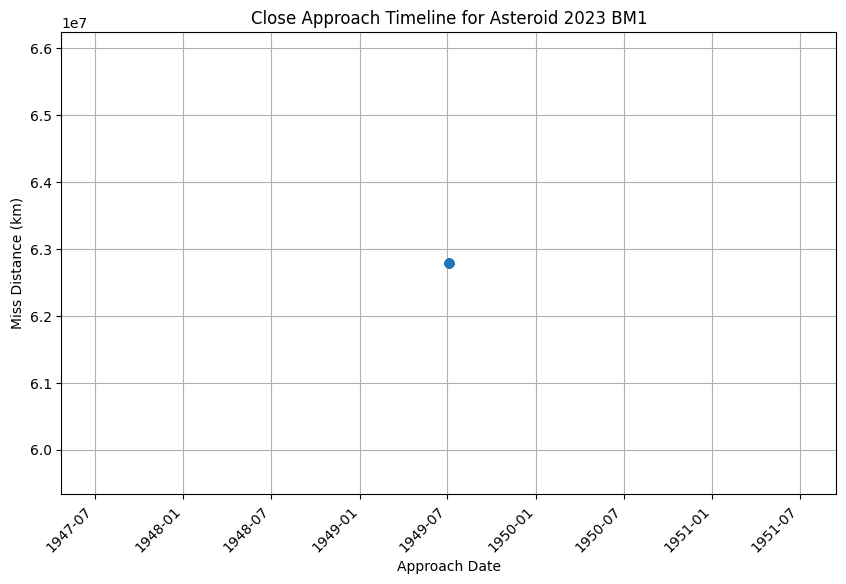

In [ ]:
import matplotlib.pyplot as plt

def draw_CAT(asteroid):
    """Draw a timeline plot of close approaches for an Asteroid object."""

    # Get approach dates and miss distances for plotting
    approach_dates = [approach.approach_date for approach in asteroid.close_approaches]
    miss_distances = [approach.miss_distance for approach in asteroid.close_approaches]

    # Create the plot
    plt.figure(figsize=(10, 6))  # Set figure size
    plt.plot(approach_dates, miss_distances, marker='o')

    # Customize the plot
    plt.title(f"Close Approach Timeline for Asteroid {asteroid.designation}")
    plt.xlabel("Approach Date")
    plt.ylabel("Miss Distance (km)")
    plt.grid(True)  # Add a grid
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels

    # Show the plot
    plt.show()

draw_CAT(asteroid)

## Challenge - Take your skills to the next level...

 With these data structures in place, we can now start answering all kinds of interesting questions about a single Asteroid or a set of Asteroids.  
Here’s a couple ideas to try:



* write a **function** named `most_dangerous_approach`, that takes a date range and returns a single “potentially hazardous” Asteroid object that makes the closest approach to Earth in within that range.  Your algorithm will ultimately need to:
    * grab the list of NEO’s for the given date range;
    * use a list comprehension to build the list of Asteroid objects for the NEO’s returned
    * use a list comprehension to filter  potentially hazardous Asteroids only;
    * use a list comprehension to map each Asteroid to its  closest_earth_approach
    * apply Python’s min function to identify the Asteroid with the closest_earth_approach

You may want to decompose some of these steps into smaller functions.
* add a method to the Asteroid class, estimated_mass, that computes an estimate of the Asteroid’s mass based on its diameter.  This is a model – state your assumptions.
* add a method to the CloseApproach class, impact_force,  that estimates the force of impact if the Asteroid hit the orbiting object.  Again, this is a model, state your assumptions.

In [ ]:
# Ex. 5 (challenge) your code here